![Kickstarer](./images/kickstarter.png)

---
Imports
---

In [ ]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly
from plotly.offline import iplot
import plotly.tools as tls

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, f1_score, confusion_matrix

import time
import json
from functions_kickstarter import *

import warnings
warnings.filterwarnings('ignore')

RSEED = 42069

In [152]:
# Import the .csv files and concat them into one dataframe
df = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')))
# Reset the indices
df.reset_index(drop=True, inplace=True)

---
#### EDA - Part 1
---

In [153]:
df.info()
# 35 targets, some of them appear to have large amounts on NaN values, object bool and int mixed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     o

In [154]:
df.isnull().sum()
# Friends, is_backing, is_starred, and permission have a lot of NaN values, can probably be dropped

backers_count                    0
blurb                            8
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
friends                     208922
fx_rate                          0
goal                             0
id                               0
is_backing                  208922
is_starrable                     0
is_starred                  208922
launched_at                      0
location                       226
name                             0
permissions                 208922
photo                            0
pledged                          0
profile                          0
slug                             0
source_url          

In [155]:
# Only a very limited amount of suspended projects (drop), canceled projects will be treated as though they failed
df['state'].value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

---
#### Data Cleaning
---

In [156]:
# Check for duplicate projects and store them in a table // Remove duplicates
dups = df.groupby(df.id.tolist()).size().reset_index().rename(columns={0:'count'})
# Sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

26958

In [157]:
# Sort dataframe by 'date_changed_at' so that we will keep the entry that was most recently updated
df.sort_values('state_changed_at')
# Remove duplicates
duplicates = df.duplicated(subset='id', keep='last')
df = df[~duplicates]

In [158]:
# Drop features which will not be needed for further analysis, most of those features are either meaningless (ex. urls), have next to no entries (ex. friends), or are bad for predictions
# See Target.md for a full list of explanation
dropped_features = ['blurb', 'currency_symbol', 'backers_count', 'is_backing', 'permissions', 'is_starred', 'source_url',
                    'slug', 'name', 'profile', 'friends', 'spotlight', 'is_starrable', 'photo', 'pledged', 'usd_type',
                    'fx_rate', 'location', 'creator', 'currency_trailing_code','current_currency', 'created_at', 'disable_communication']
df = df.drop(dropped_features, axis=1)

In [159]:
# We limit our dataset to goals below 1 Million, values above are treated as outliers
df = df.query('goal < 1000000')

---
#### Feature Engineering
---

In [160]:
# Extract category from category column
df['category'] = df['category'].apply(lambda x: json.loads(x)['slug'])
df['category'] = df['category'].apply(lambda x: x.split('/',)[0])

In [161]:
# Generate new column with readable timeformat
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')

df['state_changed_at'] = pd.to_datetime(df['state_changed_at'], unit='s')
# Add the deadline date as date column
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

In [162]:
# Add new column 'time' that displays the time from project launch to project end
#df.eval('time = state_changed_at - launched_at', inplace=True)                                 /////
df.eval('duration = deadline - launched_at', inplace=True)
# Convert to days
#df['time'] = df['time'].apply(lambda x: pd.Timedelta(x).days)                                  /////
df['duration'] = df['duration'].apply(lambda x: pd.Timedelta(x).days)

In [163]:
# Displays the goal converted to one currency (usd)
df.eval('goal = goal * static_usd_rate', inplace=True)

In [164]:
# Create a column that displays the month of launch
df['launched_at'] = df['launched_at'].apply(lambda x: pd.to_datetime(x, unit='s')).dt.month

---
### EDA - Part 2
---

#### Plots

In [ ]:
# Categorical data for bar plots
categorical = ['country','currency', 'staff_pick', 'category']
bar_plot(df, categorical)
# Takeaways: By far the most projects are from the US, Staff Picks are only rarely used, most projects are sized between 0 and 20k Dollar.

In [ ]:
plt.figure(figsize = (12,3))
plt.hist(df['goal'], color = '#87c442', edgecolor = 'black',range = [0, 20000])
plt.ylabel('# of Projects')
plt.xlabel('USD')
plt.title('Goal')
plt.show()

In [ ]:
cnt_st= df.groupby('state')['state'].count()
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,8))
colors = ['#FF9999', '#FFC000', '#8FD9B6', '#D395D0']
explode= [0.05,0.05,0.1,0.05,0.05]
plt.pie(cnt_st.values,labels=cnt_st.index.values,
        autopct='%.1f%%',
        explode=explode,
        shadow=False,
        colors=sns.color_palette('BuGn', 4),#(‘bright’)[0:5],
        textprops={'fontsize':15})
plt.title('Pie chart : Projects\' States',fontsize=20,fontweight='bold')
plt.legend(loc='upper right', fontsize=11)

# Takeaway: About half of the projects succeed

In [ ]:
df_kick = df.loc[df['state'].isin(['failed','successful'])]
df_failed = df_kick[df_kick['state'] == 'failed'].sample(10000, replace=True)
df_sucess = df_kick[df_kick['state'] == 'successful'].sample(10000, replace=True)
#First plot
trace0 = go.Histogram(
    x= np.log(df_kick.goal + 1),
    histnorm='probability', marker=dict(color='#229954'), showlegend=False,
    xbins=dict(
        start=-5.0,
        end=19.0,
        size=1),
    autobiny=True)
#Second plot
trace1 = go.Histogram(
    x = np.log(df_kick.usd_pledged + 1),
    histnorm='probability', marker=dict(color='#0B5345'), showlegend=False,
    xbins=dict(
        start=-1.0,
        end=17.0,
        size=1))
# Add histogram data
failed = np.log(df_failed['goal']+1)
success = np.log(df_sucess['goal']+1)
trace3 = go.Histogram(
    x=failed,
    opacity=0.60, nbinsx=30, name='Goals Failed', histnorm='probability', marker=dict(color='#2ECC71')
)
trace4 = go.Histogram(
    x=success,
    opacity=0.60, nbinsx=30, name='Goals Sucessful', histnorm='probability', marker=dict(color='#145A32')
)
data = [trace0, trace1, trace3, trace4]
layout = go.Layout(barmode='overlay')
#Creating the grid
fig = plotly.tools.make_subplots(rows=2, cols=2, specs=[ [{'colspan': 2}, None], [{}, {}]],
                          subplot_titles=('Failed and Sucessful Projects',
                                          'Goal','Pledged'))
#setting the figs
fig.append_trace(trace0, 2, 1)
fig.append_trace(trace1, 2, 2)
fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)
fig['layout'].update(title='Distribuitions',
                     height=500, width=900, barmode='overlay')
iplot(fig)

In [ ]:
df_kick2 = df.loc[df['state'].isin(['failed','successful'])]
main_cats = df_kick2['category'].value_counts()
main_cats_failed = df_kick2[df_kick2['state'] == 'failed']['category'].value_counts()
main_cats_sucess = df_kick2[df_kick2['state'] == 'successful']['category'].value_counts()
#First plot
trace0 = go.Bar(
    x=main_cats_failed.index,
    y=main_cats_failed.values,
    name='Failed Categories', marker=dict(color='#ABEBC6')
)
#Second plot
trace1 = go.Bar(
    x=main_cats_sucess.index,
    y=main_cats_sucess.values,
    name='Success Categories', marker=dict(color='#2ECC71')
)
#Third plot
trace2 = go.Bar(
    x=main_cats.index,
    y=main_cats.values,
    name='Categories Distributiion', marker=dict(color='#145A32')
)
#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Failed','Sucessful', "General Category's"))
#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
z=[12,24,48]
fig['layout'].update(showlegend=True,
                     title="Main Category's Distribuition",
                     bargap=0.05, height = 600, width = 800)
iplot(fig)

# Takeaway Tech seems to have a high failure rate but is quite succesful

In [ ]:
array_live = ['live']
live_projects = df.loc[df['state'].isin(array_live)]
# Filter and concat. for target variable
array_notlive = ['successful', 'failed', 'canceled']
df = df.loc[df['state'].isin(array_notlive)]
# Add canceled to failed projects
df.replace('canceled','failed', inplace=True)
# Replace successful and failed entries with 0 and 1
#df.replace(['successful','failed'],[1,0], inplace=True)
df_new=df.groupby('staff_pick')['state'].value_counts(normalize=True)
df_new =df_new.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='state', y='Percent', hue='staff_pick', kind='bar', data=df_new, palette=sns.color_palette(['#222222', '#05ce78']))
g.fig.set_size_inches(15,10)
g.ax.set_ylim(0,100)
g.set_xlabels('State',fontsize=25)
g.set_ylabels('Percentage in %',fontsize=25)
g.set(title='Staff Pick Influence on Success of Projects')
#sns.set(font_scale = 2)
plt.legend(fontsize='small', title_fontsize='25')
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x, txt_y,txt)

# Takeaway: There seems to be a strong influence on the projects success depending on a staff pick

----
### Feature Engineering - Part 2
----

#### Drop columns and set aside live projects

In [165]:
# Set aside columns for later use on predicted live projects
list = ['urls','state','staff_pick']
alive_feature_list = df[list]

# Extract urls from web dict
alive_feature_list['urls'] = alive_feature_list['urls'].apply(lambda x: json.loads(x)['web'])
# Only take those values where state is equal to live state
array_live = ['live']
alive_feature_list = alive_feature_list.loc[alive_feature_list['state'].isin(array_live)]
# Drop state again
alive_feature_list.drop('state', axis=1, inplace=True)

In [166]:
# Drop id (not needed anymore), converted pledged amount/usd_pledged (predictor not av. at the beginning of a project),
# country (redundant with currency), drop staff_pick bc we dont know the staff pick when we make predictions
drop_list = ['id','converted_pledged_amount', 'usd_pledged', 'country', 'urls', 'static_usd_rate', 'staff_pick', 'state_changed_at', 'deadline']
df.drop(drop_list, axis = 1, inplace = True)

#### One-hot encoding

In [168]:
# One hot encode all categorical data (currency, categories)
one_hot_featurelist = ['currency', 'category', 'launched_at']
one_hot = pd.get_dummies(df[one_hot_featurelist])
df.drop(one_hot_featurelist, axis = 1, inplace=True)
df = df.join(one_hot)

#### Standardization and Target Engineering

In [169]:
# Standardize numerical data according to a min-max scaler
numerical = ['goal']
df = scale_columns(df, numerical)

In [170]:
# Extract live values
array_live = ['live']
ongoing_projects = df.loc[df['state'].isin(array_live)]

# Filter target variable
array_notlive = ['successful', 'failed', 'canceled']

df = df.loc[df['state'].isin(array_notlive)]
# Add canceled to failed projects
df.replace('canceled','failed', inplace=True)
# Replace successful and failed entries with 0 and 1
df.replace(['successful','failed'],[1,0], inplace=True)

----
### Modelling
----

#### Dummy Classifier and Baseline Model

In [172]:
# Set x and y
X = df.drop('state', axis = 1)
y = df['state']

In [173]:
# The dummy classifier predicts with a 53% precision if a project will succeed or fail
dummy = DummyClassifier(strategy='stratified', random_state=RSEED, constant=None)
dummy.fit(X,y)

y_pred = dummy.predict(X)
precision_score(y, y_pred)

0.5363663226323899

In [174]:
confusion_matrix(y, y_pred)

array([[38065, 43933],
       [43891, 50825]])

#### Train Model

In [175]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=RSEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((123699, 32), (53015, 32), (123699,), (53015,))

In [176]:
# List of models used
models = []

models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(GradientBoostingClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1))
models.append(KNeighborsClassifier())
models.append(XGBClassifier())

In [177]:
# Amount of volding for cross-validation
kfold = StratifiedKFold(n_splits=5)

go: LogisticRegression()


/Users/maxh/neuerfische/Kickstarter_Challenge/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maxh/neuerfische/Kickstarter_Challenge/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

end: LogisticRegression()
go: DecisionTreeClassifier()
end: DecisionTreeClassifier()
go: RandomForestClassifier()
end: RandomForestClassifier()
go: GradientBoostingClassifier()
end: GradientBoostingClassifier()
go: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1)
end: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1)
go: KNeighborsClassifier()
end: KNeighborsClassifier()
go: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monot

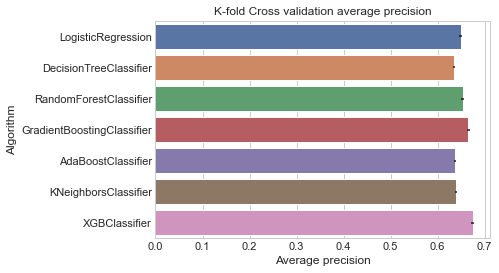

In [178]:
# Find cross validation scores from list of models. The target is f1. Time is also accounted for to find the most effective models
cv_results = []
cv_names = []
cv_times = []

for model in models:
    start_time = time.time()
    print('go:', model)
    cv_results.append(cross_val_score(model, X_train, y = y_train, scoring = "precision", cv = kfold, n_jobs=4, verbose=0))
    cv_names.append(model.__class__.__name__)
    end_time = time.time()
    total_time = round(end_time - start_time ,2)
    cv_times.append(total_time)
    print('end:', model)

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":cv_names, "Time needed for training":cv_times})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res,orient = "h",**{'xerr':cv_std})
g.set_xlabel("Average precision")
g = g.set_title("K-fold Cross validation average precision")

In [179]:
cv_res['criterion'] = cv_res.CrossValMeans - cv_res.CrossValerrors/2
cv_res.sort_values(by='criterion', ascending=False)
# We select XGBClassifier, and RandomForestClassifier for hyperparameter tuning

CrossValMeans  CrossValerrors                   Algorithm  \
6       0.674581        0.003494               XGBClassifier   
3       0.665551        0.002981  GradientBoostingClassifier   
2       0.653050        0.002969      RandomForestClassifier   
0       0.649314        0.003479          LogisticRegression   
5       0.638183        0.002016        KNeighborsClassifier   
4       0.636827        0.001379          AdaBoostClassifier   
1       0.634239        0.002583      DecisionTreeClassifier   

   Time needed for training  criterion  
6                     17.99   0.672834  
3                     12.70   0.664060  
2                     15.80   0.651565  
0                      3.98   0.647574  
5                    117.80   0.637175  
4                     37.36   0.636138  
1                      0.97   0.632948

In [180]:
### XGB classifier

XGB = XGBClassifier()

max_depth = [1,2,4,8,10]
min_child_weight = np.linspace(1, 10, 5, endpoint=True) 

gamma = np.linspace(0.5, 5, 5, endpoint=True)
subsample = np.linspace(0.5, 1, 5, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, 5, endpoint=True)

XGB_param_grid = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth
        }


gsXGB = HalvingGridSearchCV(estimator = XGB, 
                    param_grid = XGB_param_grid, cv=kfold, scoring="precision", n_jobs= 4, verbose = 1)

gsXGB.fit(X_train,y_train)

XGB_best = gsXGB.best_estimator_
print(XGB_best.get_params())

# Best score
gsXGB.best_score_

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 56
max_resources_: 123699
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3125
n_resources: 56
Fitting 5 folds for each of 3125 candidates, totalling 15625 fits


/Users/maxh/neuerfische/Kickstarter_Challenge/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxh/neuerfische/Kickstarter_Challenge/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxh/neuerfische/Kickstarter_Challenge/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

----------
iter: 1
n_candidates: 1042
n_resources: 168
Fitting 5 folds for each of 1042 candidates, totalling 5210 fits
----------
iter: 2
n_candidates: 348
n_resources: 504
Fitting 5 folds for each of 348 candidates, totalling 1740 fits
----------
iter: 3
n_candidates: 116
n_resources: 1512
Fitting 5 folds for each of 116 candidates, totalling 580 fits
----------
iter: 4
n_candidates: 39
n_resources: 4536
Fitting 5 folds for each of 39 candidates, totalling 195 fits
----------
iter: 5
n_candidates: 13
n_resources: 13608
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 6
n_candidates: 5
n_resources: 40824
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 7
n_candidates: 2
n_resources: 122472
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytre

0.6742028273071123

In [181]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

## Search grid for optimal parameters
rf_param_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": ["gini"]}
              

gsRFC = HalvingGridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="precision", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

print(RFC_best.get_params())


# Best score
gsRFC.best_score_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1527
max_resources_: 123699
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 192
n_resources: 1527
Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------
iter: 1
n_candidates: 64
n_resources: 4581
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 2
n_candidates: 22
n_resources: 13743
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 3
n_candidates: 8
n_resources: 41229
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 123687
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_lea

0.6764718112257417

In [182]:
# Voting Classifier (soft voting) including the three best models after grid search
votingC = VotingClassifier(estimators=[ ('XGB',XGB_best), ("RandomForest",RFC_best)], voting='soft', n_jobs=4)
# Fit train data to Voting Classifier
votingC = votingC.fit(X_train, y_train)
# Make predictions on test data
votingC_predict = votingC.predict(X_test)

In [189]:
# Returns an array for the probability of all classes ordered by the label of classes
votingC_predict_proba = votingC.predict_proba(X_test)

# Precision Score on test data
precision_score(votingC_predict, y_test)

0.7672238218976052

In [ ]:
# Confusion matrix
cfm = confusion_matrix(votingC_predict, y_test)
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

#### Error Analysis

In [184]:
# Reset index of y_test data
y_test_use = y_test.reset_index().drop('index', axis=1)

# Get a dataframe with the prediction probabilities
votingC_predict_proba = pd.DataFrame(votingC_predict_proba)

# Replace column headers with Failed, Successful strings
votingC_predict_proba = votingC_predict_proba.rename({0: 'Failed', 1: 'Successful'}, axis='columns')

# Add the real y_test data
votingC_predict_proba['y_test'] = y_test_use

# Replace 0's and 1's in the y_test column
votingC_predict_proba['y_test'] = votingC_predict_proba['y_test'].map({1: 'Successful', 0: 'Failed'})

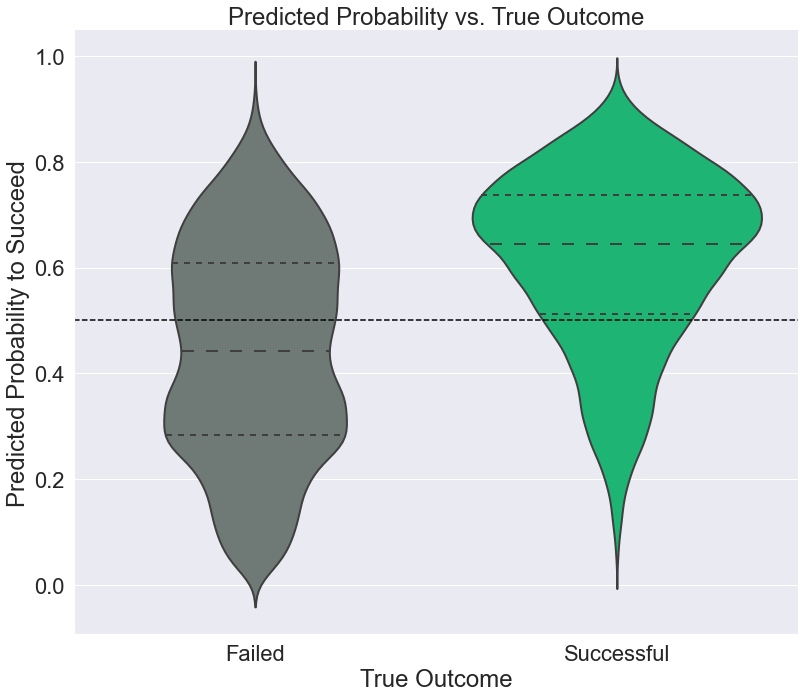

In [188]:
# Violin plot of the prediction probabilities of the violin plot against the true values 'y' of our test set
ax = sns.catplot(x="y_test", y="Successful", data=votingC_predict_proba, kind="violin", palette=sns.color_palette(['#6d7b75', '#05ce78']), linewidth = 2,
                inner = "quartile")
ax.set(xlabel='True Outcome', ylabel='Predicted Probability to Succeed')
ax.fig.set_size_inches(15,12)
sns.set(font_scale = 2)
plt.axhline(0.5, color = 'black', linestyle = '--')
ax.set(title='Predicted Probability vs. True Outcome')
plt.show();

#### Make Predictions on live dataset

In [190]:
# Set x for live datasets by dropping the state
X_array_live = ongoing_projects.drop('state', axis = 1)

In [192]:
# Use live set to predict the probabilities of success
votingC_predict_proba_live = votingC.predict_proba(X_array_live)
votingC_predict_proba_live = pd.DataFrame(votingC_predict_proba_live)
votingC_predict_proba_live = votingC_predict_proba_live.rename({0: 'Failed', 1: 'Successful'}, axis='columns')

In [194]:
# Make predictions
ongoing_projects_pred = votingC.predict(X_array_live)

In [196]:
alive_feature_list['prediction'] = ongoing_projects_pred.tolist()

In [198]:
# Replace 1, 0 entries with successful and failed
alive_feature_list['prediction']  = alive_feature_list['prediction'].replace([1,0], ['successful','failed'])

In [200]:
alive_feature_list_2 = alive_feature_list.reset_index().drop('index', axis=1)

In [202]:
predictions_live = pd.concat([alive_feature_list_2, votingC_predict_proba_live], axis=1)

In [233]:
# Select all projects that are successful and get a random sample
query_entry = predictions_live.query('Successful > 0.5 & Successful < 0.7').sample(100)

In [234]:
query_entry
# Variance plus confidence interval = sample # Power analysis

urls  staff_pick  \
1     {'project': 'https://www.kickstarter.com/proje...       False   
9     {'project': 'https://www.kickstarter.com/proje...       False   
14    {'project': 'https://www.kickstarter.com/proje...       False   
15    {'project': 'https://www.kickstarter.com/proje...       False   
18    {'project': 'https://www.kickstarter.com/proje...       False   
...                                                 ...         ...   
3989  {'project': 'https://www.kickstarter.com/proje...       False   
3993  {'project': 'https://www.kickstarter.com/proje...       False   
4003  {'project': 'https://www.kickstarter.com/proje...       False   
4006  {'project': 'https://www.kickstarter.com/proje...       False   
4011  {'project': 'https://www.kickstarter.com/proje...        True   

      prediction    Failed  Successful  
1     successful  0.362458    0.637542  
9     successful  0.373049    0.626951  
14    successful  0.331915    0.668085  
15    successful  0.431047    0.568953  
18    successful  0.318970    0.681030  
...          ...       ...         ...  
3989  successful  0.377081    0.622919  
3993  successful  0.376569    0.623431  
4003  successful  0.375587    0.624413  
4006  successful  0.496698    0.503302  
4011  successful  0.323292    0.676708  

[1476 rows x 5 columns]

In [226]:
# Look at random samples, how did our prediction perform on real life cases?
query_entry.iat[0,0]

{'project': 'https://www.kickstarter.com/projects/belleregalia/raven-boys-bookish-enamel-pin-collection?ref=discovery_category_newest',
 'rewards': 'https://www.kickstarter.com/projects/belleregalia/raven-boys-bookish-enamel-pin-collection/rewards'}